# **Setup geral**


In [3]:
from google.colab import drive
import pandas as pd
import torch
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer
import torch.nn.functional as F
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from tqdm import tqdm
import nltk

In [24]:
from transformers import EarlyStoppingCallback

In [28]:
from transformers import RobertaConfig, RobertaForSequenceClassification

In [4]:
# from google.colab import drive
print("Montando o Google Drive...")
# force_remount=True garante que ele peça autorização mesmo que já montado
drive.mount('/content/drive', force_remount=True)
print("Drive montado com sucesso!")

Montando o Google Drive...
Mounted at /content/drive
Drive montado com sucesso!


In [5]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
# Caminhos
BASE_PATH = "/content/drive/MyDrive/colab_lm/"
CLEF_TRAIN = os.path.join(BASE_PATH, "subj/train_en.tsv")
CLEF_TEST = os.path.join(BASE_PATH, "subj/dev_en.tsv")

# Dados SemEval (Alvo da anotação)
SEMEVAL_RAW = os.path.join(BASE_PATH, "detec/subtaskA_train_monolingual.jsonl")
SEMEVAL_SENTENCES = os.path.join(BASE_PATH, "detec/subtaskA_train_monolingual_sentences.jsonl") # Corrigido aqui

# Onde salvar o modelo e os resultados
MODEL_SAVE_PATH = os.path.join(BASE_PATH, "modelo/subj-classifier-roberta") # Corrigido aqui
OUTPUT_SCORES = os.path.join(BASE_PATH, "detec/semeval_subjectivity_scores.json")

# Configurações
MODEL_NAME = "roberta-base"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Pré-processamento

Vamos preparar os dados da tarefa de detecção de IA para serem analisados pelo modelo de subjetividade

Os textos longos são **divididos em sentenças** individuais usando NLTK, garantindo que o modelo de subjetividade, treinado em frases curtas, não perca informação

In [7]:
BASE_DETEC = "/content/drive/MyDrive/colab_lm/detec"

FILES_TO_PROCESS = [
    "subtaskA_train_monolingual.jsonl",
    "subtaskA_dev_monolingual.jsonl",
    "subtaskA_test_monolingual.jsonl"
]

def split_text_into_sentences(filename):
    input_path = os.path.join(BASE_DETEC, filename)

    if not os.path.exists(input_path):
        print(f"Arquivo não encontrado: {input_path}")
        return

    print(f"\nProcessando: {filename} ...")

    # arquivo de saída
    output_filename = filename.replace(".jsonl", "_sentences.jsonl")
    output_path = os.path.join(BASE_DETEC, output_filename)

    # lendo o arquivo original
    df = pd.read_json(input_path, lines=True)

    new_rows = []

    # iterando por cada texto original
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Quebrando frases"):
        original_text = row['text']
        original_id = row['id']

        # campos opcionais
        label = row.get('label')
        model_src = row.get('model')
        source = row.get('source')

        # quebrando o texto em sentenças gramaticalmente corretas
        try:
            sentences = nltk.sent_tokenize(str(original_text), language='english')
        except:
            sentences = [str(original_text)] # Fallback se der erro

        # criando uma nova linha para cada sentença
        for i, sent in enumerate(sentences):
            # ignorando frases muito curtas (ruído)
            if len(sent.strip()) < 5:
                continue

            new_item = {
                "sentence_id": f"{original_id}_{i}", # ID único para a frase
                "doc_id": original_id, # ID do texto original
                "text": sent, # a frase individual
                "label": label, # herda o label do pai (0 ou 1)
                "model": model_src,
                "source": source
            }
            new_rows.append(new_item)

    print(f"Salvando {len(new_rows)} frases em {output_filename}...")

    # json
    with open(output_path, 'w', encoding='utf-8') as f:
        for item in new_rows:
            f.write(json.dumps(item) + '\n')

    print("Concluído!")

for file in FILES_TO_PROCESS:
    split_text_into_sentences(file)


Processando: subtaskA_train_monolingual.jsonl ...


Quebrando frases: 100%|██████████| 119757/119757 [01:08<00:00, 1742.49it/s]


Salvando 2717857 frases em subtaskA_train_monolingual_sentences.jsonl...
Concluído!

Processando: subtaskA_dev_monolingual.jsonl ...


Quebrando frases: 100%|██████████| 5000/5000 [00:02<00:00, 2198.76it/s]


Salvando 83083 frases em subtaskA_dev_monolingual_sentences.jsonl...
Concluído!

Processando: subtaskA_test_monolingual.jsonl ...


Quebrando frases: 100%|██████████| 34272/34272 [00:16<00:00, 2116.72it/s]


Salvando 629672 frases em subtaskA_test_monolingual_sentences.jsonl...
Concluído!


# **Treinamento**

In [14]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/colab_lm/subj/train_en.tsv', sep='\t')

df = df.rename(columns={"sentence": "text", "label": "label"})

label_map = {"OBJ": 0, "SUBJ": 1}
df['label'] = df['label'].map(label_map)

# separando um conjunto de validação para monitorar o treinamento
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.1, # validação
    random_state=42
)

In [15]:
# from transformers import RobertaTokenizer

MODEL_NAME = "roberta-base"

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [16]:
# import torch

class SubjectivityDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # construindo um dicionário para cada item
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SubjectivityDataset(train_encodings, train_labels)
val_dataset = SubjectivityDataset(val_encodings, val_labels)

In [37]:
# from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
# from sklearn.metrics import f1_score
# import numpy as np

# carregando o modelo pré-treinado
# num_labels: OBJ e SUBJ
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# função para calcular as métricas
# a métrica oficial da CLEF Task 1 é o macro-averaged F1
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {
        'macro_f1': macro_f1,
    }

# caminho base para salvar o modelo
DRIVE_PATH = '/content/drive/MyDrive/colab_lm/modelo/'

training_args = TrainingArguments(
    output_dir=f'{DRIVE_PATH}results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",     # avaliar a cada época
    save_strategy="epoch",           # salvar o modelo a cada época
    load_best_model_at_end=True,     # carregar o melhor modelo no final
    metric_for_best_model="macro_f1",
    report_to="none", # Desabilitar o reporte para o Weights & Biases
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics, # <- passando a nossa função de métrica
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# Iniciar o treinamento
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1
1,No log,0.643532,0.402878
2,No log,0.571369,0.402878
3,0.643900,0.486761,0.737223
4,0.643900,0.483905,0.828276
5,0.397700,0.403826,0.783532
6,0.397700,0.972679,0.692845


TrainOutput(global_step=282, training_loss=0.4439968961350461, metrics={'train_runtime': 84.9263, 'train_samples_per_second': 87.959, 'train_steps_per_second': 5.534, 'total_flos': 294815937530880.0, 'train_loss': 0.4439968961350461, 'epoch': 6.0})

In [39]:
# Salvar o modelo final e o tokenizador
MODEL_SAVE_PATH = f"{DRIVE_PATH}subj-classifier-roberta" # <-- Salva no Drive
trainer.save_model(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

print(f"Modelo salvo em: {MODEL_SAVE_PATH}")

Modelo salvo em: /content/drive/MyDrive/colab_lm/modelo/subj-classifier-roberta


# **Carregando e configurando o modelo**

In [40]:
MODEL_PATH = "/content/drive/MyDrive/colab_lm/modelo/subj-classifier-roberta"
CHECKPOINT_DIR = "/content/drive/MyDrive/colab_lm/checkpoints/"

# Criar o diretório de checkpoints se ele não existir
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"Carregando modelo de: {MODEL_PATH}")
tokenizer = RobertaTokenizer.from_pretrained(MODEL_PATH)
model = RobertaForSequenceClassification.from_pretrained(MODEL_PATH)

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Modelo pronto para uso no dispositivo: {device}")

Carregando modelo de: /content/drive/MyDrive/colab_lm/modelo/subj-classifier-roberta
Modelo pronto para uso no dispositivo: cuda


# **Avaliação**

Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Caminhos verificados.
Carregando modelo de: /content/drive/MyDrive/colab_lm/modelo/subj-classifier-roberta
Carregando teste de: /content/drive/MyDrive/colab_lm/subj/dev_en.tsv
Modelo carregado e rodando em: cuda
Tokenizando dados de teste...
Executando predição no conjunto de teste...



RESULTADOS DO TESTE DE SUBJETIVIDADE
Acurácia: 0.7511
F1 Macro: 0.7498

Relatório de Classificação
               precision    recall  f1-score   support

 Objetivo (0)       0.70      0.86      0.77       222
Subjetivo (1)       0.83      0.65      0.73       240

     accuracy                           0.75       462
    macro avg       0.76      0.76      0.75       462
 weighted avg       0.77      0.75      0.75       462



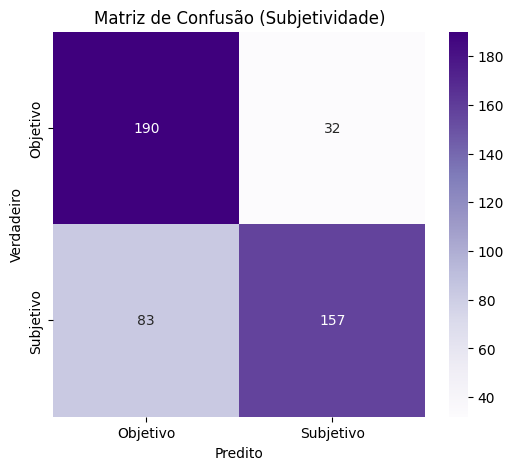

In [44]:
# teste final de subjetividade com os dados oficiais da tarefa do CLEF

import pandas as pd
import torch
import numpy as np
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments # Importar TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("Montando Google Drive...")
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/colab_lm/"
MODEL_PATH = os.path.join(BASE_DIR, "modelo/subj-classifier-roberta") # Onde seu modelo está salvo
TEST_FILE_PATH = os.path.join(BASE_DIR, "subj/dev_en.tsv") # O arquivo de teste (dev_en.tsv)

if not os.path.exists(MODEL_PATH) or not os.path.exists(TEST_FILE_PATH):
    print(f"ERRO: Verifique os caminhos!\nModelo: {MODEL_PATH}\nTeste: {TEST_FILE_PATH}")
else:
    print(f"Caminhos verificados.\nCarregando modelo de: {MODEL_PATH}\nCarregando teste de: {TEST_FILE_PATH}")

    try:
        tokenizer = RobertaTokenizer.from_pretrained(MODEL_PATH)
        model = RobertaForSequenceClassification.from_pretrained(MODEL_PATH)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        print(f"Modelo carregado e rodando em: {device}")
    except Exception as e:
        print(f"Erro ao carregar o modelo: {e}")
        raise e

    # dados de teste
    df_test = pd.read_csv(TEST_FILE_PATH, sep='\t')


    label_map = {"OBJ": 0, "SUBJ": 1}
    if 'label' in df_test.columns and isinstance(df_test['label'].iloc[0], str):
         df_test['label'] = df_test['label'].map(label_map)

    # criar dataset simples para o PyTorch
    class SimpleDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels
        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            if self.labels is not None:
                item['labels'] = torch.tensor(self.labels[idx])
            return item
        def __len__(self):
            return len(self.labels)

    print("Tokenizando dados de teste...")
    test_encodings = tokenizer(df_test['sentence'].tolist(), truncation=True, padding=True, max_length=128)
    test_dataset = SimpleDataset(test_encodings, df_test['label'].tolist())

    # Criar TrainingArguments com report_to="none" para evitar o wandb
    eval_training_args = TrainingArguments(
        output_dir="./eval_results", # Diretório de saída temporário
        report_to="none",            # Desativar o reporte para o Weights & Biases
        per_device_eval_batch_size=64, # Apenas para avaliação, pode ser um batch maior
    )

    trainer_eval = Trainer(
        model=model,
        args=eval_training_args, # Passar os argumentos de treinamento
    )

    print("Executando predição no conjunto de teste...")
    predictions = trainer_eval.predict(test_dataset)

    # convertendo logits para classes (0 ou 1)
    preds = np.argmax(predictions.predictions, axis=-1)
    labels = predictions.label_ids

    print("\nRESULTADOS DO TESTE DE SUBJETIVIDADE")

    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average='macro')
    print(f"Acurácia: {acc:.4f}")
    print(f"F1 Macro: {f1_macro:.4f}")

    print("\nRelatório de Classificação")
    print(classification_report(labels, preds, target_names=['Objetivo (0)', 'Subjetivo (1)']))


    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=['Objetivo', 'Subjetivo'],
                yticklabels=['Objetivo', 'Subjetivo'])
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.title('Matriz de Confusão (Subjetividade)')
    plt.show()

# **Cálculo de Subjetividade + Classificação de Detecção**

In [45]:
def predict_subjectivity(texts, model, tokenizer, batch_size=128): # <--- Aumentei o batch_size padrão
    model.eval()
    all_scores = []

    dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
    print(f"Rodando inferência com precisão: {dtype}")

    # loop de inferência
    for i in tqdm(range(0, len(texts), batch_size), desc="Calculando Subjetividade"):
        batch = texts[i:i+batch_size]

        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(DEVICE)

        with torch.no_grad():
            # autocast
            with torch.amp.autocast(device_type="cuda", dtype=dtype):
                outputs = model(**inputs)
                probs = F.softmax(outputs.logits, dim=1)
                scores = probs[:, 1].float().cpu().numpy()
                all_scores.extend(scores)

    return all_scores

In [46]:
print("Carregando sentenças da tarefa de detecção...")
df_sentences = pd.read_json(SEMEVAL_SENTENCES, lines=True)

print(f"Total de sentenças: {len(df_sentences)}")

tokenizer = RobertaTokenizer.from_pretrained(MODEL_SAVE_PATH)
model = RobertaForSequenceClassification.from_pretrained(MODEL_SAVE_PATH).to(DEVICE)

scores = predict_subjectivity(df_sentences['text'].tolist(), model, tokenizer)
df_sentences['subj_score'] = scores

Carregando sentenças da tarefa de detecção...
Total de sentenças: 2717857
Rodando inferência com precisão: torch.bfloat16


Calculando Subjetividade: 100%|██████████| 21234/21234 [20:59<00:00, 16.85it/s]


In [47]:
# agregação

print("Agregando scores por documento...")
doc_level_scores = df_sentences.groupby('doc_id')['subj_score'].mean().reset_index()
doc_level_scores.rename(columns={'subj_score': 'mean_subjectivity'}, inplace=True)

doc_level_scores.to_json(OUTPUT_SCORES, orient='records', lines=True)
print(f"Scores de subjetividade salvos em: {OUTPUT_SCORES}")
print(doc_level_scores.head())

Agregando scores por documento...
Scores de subjetividade salvos em: /content/drive/MyDrive/colab_lm/detec/semeval_subjectivity_scores.json
   doc_id  mean_subjectivity
0       0           0.179209
1       1           0.071992
2       2           0.037683
3       3           0.035385
4       4           0.160284


In [48]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import torch
import json
import torch.nn.functional as F

if 'BASE_DIR' not in locals():
    BASE_DIR = "/content/drive/MyDrive/colab_lm/"

SENTENCES_FILE = os.path.join(BASE_DIR, "detec", "subtaskA_test_monolingual_sentences.jsonl")
ORIGINAL_FILE = os.path.join(BASE_DIR, "detec", "subtaskA_test_monolingual.jsonl")
GOLD_LABELS_FILE = os.path.join(BASE_DIR, "detec", "subtaskA_gold_monolingual.jsonl")
RESULTS_FILE = os.path.join(BASE_DIR, "resultados_finais_teste.jsonl")

MODEL_SUBJ_PATH = os.path.join(BASE_DIR, "modelo/subj-classifier-roberta")
MODEL_AI_DET_PATH = os.path.join(BASE_DIR, "ai-detector-roberta")

if 'model_subj' not in locals() or 'model_ai' not in locals():
    print("Carregando modelos...")

    def load_model_local(path):
        from transformers import AutoTokenizer, RobertaForSequenceClassification
        tokenizer = AutoTokenizer.from_pretrained(path)
        model = RobertaForSequenceClassification.from_pretrained(path)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()
        return tokenizer, model

    tokenizer_subj, model_subj = load_model_local(MODEL_SUBJ_PATH)
    tokenizer_ai, model_ai = load_model_local(MODEL_AI_DET_PATH)

    tok_ai, mod_ai = tokenizer_ai, model_ai
    print("Modelos carregados!")

def predict_batch(texts, current_tokenizer, current_model, task_type):
    """
    recebe uma lista de textos, um tokenizador, um modelo e o tipo de tarefa ('subjectivity' ou 'detection')
    e retorna as pontuações/previsões correspondentes
    """
    try:
        inputs = current_tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = current_model(**inputs)

        if task_type == "subjectivity":
            probs = F.softmax(outputs.logits, dim=1)
            # retorna a probabilidade da classe 1, subj
            scores = probs[:, 1].cpu().numpy()
            return scores
        elif task_type == "detection":
            # retorna a classe predita, 0 ou 1
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            return preds
        else:
            raise ValueError(f"Tipo de tarefa desconhecido: {task_type}")

    except Exception as e:
        print(f"Erro ao processar lote para {task_type}: {e}. Retornando valores padrão.")
        if task_type == "subjectivity":
            return np.full(len(texts), -1.0) # Retorna -1 para erro na subjetividade
        elif task_type == "detection":
            # Retorna 0 (humano) em caso de erro na detecção como valor padrão
            return np.full(len(texts), 0)


print("\nCalculando Subjetividade das Frases")
doc_scores_raw = {}
doc_scores = {}

chunksize = 2000
total_sentences = 0

if not os.path.exists(SENTENCES_FILE):
    print(f"Erro: Arquivo de sentenças não encontrado: {SENTENCES_FILE}")
else:
    for chunk in tqdm(pd.read_json(SENTENCES_FILE, lines=True, chunksize=chunksize), desc="Processando Frases"):
        texts = [str(t) for t in chunk['text'].tolist()]
        doc_ids = chunk['doc_id'].tolist()

        # predict de subjetividade
        scores = predict_batch(texts, tokenizer_subj, model_subj, "subjectivity")

        for i, doc_id in enumerate(doc_ids):
            if doc_id not in doc_scores_raw:
                doc_scores_raw[doc_id] = []
            doc_scores_raw[doc_id].append(scores[i])

        total_sentences += len(texts)

    # média por documento
    for doc_id, scores_list in doc_scores_raw.items():
        doc_scores[doc_id] = np.mean(scores_list)
    print(f"Subjetividade calculada para {len(doc_scores)} documentos.")

# classificação de detecção (cruzamento)
print("\n--- Etapa 2: Classificando Textos de Detecção")

if os.path.exists(GOLD_LABELS_FILE):
    print("Carregando Gold Labels...")
    df_gold = pd.read_json(GOLD_LABELS_FILE, lines=True)
    gold_dict = dict(zip(df_gold['id'], df_gold['label']))
else:
    print("Gold Labels não encontrados! Usando labels do arquivo original")
    gold_dict = {}

df_orig = pd.read_json(ORIGINAL_FILE, lines=True)
final_results = []

BATCH_SIZE = 32
texts_buffer = []
ids_buffer = []
labels_buffer = []

for index, row in tqdm(df_orig.iterrows(), total=len(df_orig), desc="Classificando Textos"):
    # Só processa se tivermos o score de subjetividade
    if row['id'] not in doc_scores:
        continue

    texts_buffer.append(str(row['text']))
    ids_buffer.append(row['id'])

    true_label = gold_dict.get(row['id'], row.get('label'))
    labels_buffer.append(true_label)

    # processar Batch
    if len(texts_buffer) >= BATCH_SIZE:
        preds = predict_batch(texts_buffer, tok_ai, mod_ai, "detection")

        for i, pred in enumerate(preds):
            doc_id = ids_buffer[i]
            avg_subj = doc_scores[doc_id] # ja temos a média pronta

            final_results.append({
                'id': doc_id,
                'true_label_ia': labels_buffer[i],
                'pred_label_ia': int(pred),
                'score_subjetividade_medio': float(avg_subj)
            })

        texts_buffer, ids_buffer, labels_buffer = [], [], []

# processar restante
if texts_buffer:
    preds = predict_batch(texts_buffer, tok_ai, mod_ai, "detection")
    for i, pred in enumerate(preds):
        doc_id = ids_buffer[i]
        avg_subj = doc_scores[doc_id]
        final_results.append({
            'id': doc_id,
            'true_label_ia': labels_buffer[i],
            'pred_label_ia': int(pred),
            'score_subjetividade_medio': float(avg_subj)
        })


df_final = pd.DataFrame(final_results)
df_final.to_json(RESULTS_FILE, orient='records', lines=True)
print(f"Análise concluída! Resultados salvos em {RESULTS_FILE}")

Carregando modelos...
Modelos carregados!

Calculando Subjetividade das Frases


Processando Frases: 0it [00:00, ?it/s]

Subjetividade calculada para 34272 documentos.

--- Etapa 2: Classificando Textos de Detecção
Carregando Gold Labels...


Classificando Textos:   0%|          | 0/34272 [00:00<?, ?it/s]

Análise concluída! Resultados salvos em /content/drive/MyDrive/colab_lm/resultados_finais_teste.jsonl


In [49]:
SEMEVAL_FILE_PATH = "/content/drive/MyDrive/colab_lm/detec/subtaskA_train_monolingual_sentences.jsonl"
print(f"Carregando dados da SemEval de: {SEMEVAL_FILE_PATH}")

if not os.path.exists(SEMEVAL_FILE_PATH):
    print("!!! ERRO: Arquivo da SemEval não encontrado. Verifique o caminho SEMEVAL_FILE_PATH.")
else:
    df_semeval = pd.read_json(SEMEVAL_FILE_PATH, lines=True)

    # (source 1): label 0 = humano, label 1 = máquina
    corpus_humano = df_semeval[df_semeval['label'] == 0]['text'].tolist()
    corpus_ia = df_semeval[df_semeval['label'] == 1]['text'].tolist()

    print(f"Textos humanos para analisar: {len(corpus_humano)}")
    print(f"Textos de IA para analisar: {len(corpus_ia)}")

Carregando dados da SemEval de: /content/drive/MyDrive/colab_lm/detec/subtaskA_train_monolingual_sentences.jsonl
Textos humanos para analisar: 1779164
Textos de IA para analisar: 938693


Carregando resultados salvos para plotagem...
Carregados 117175 scores humanos
Carregados 56406 scores de IA
0 erros removidos do corpus humano.
0 erros removidos do corpus de IA.

Médias de Subjetividade
Média (Humano): 0.1962
Média (IA):     0.1882
Mediana (Humano): 0.1456
Mediana (IA):     0.1663


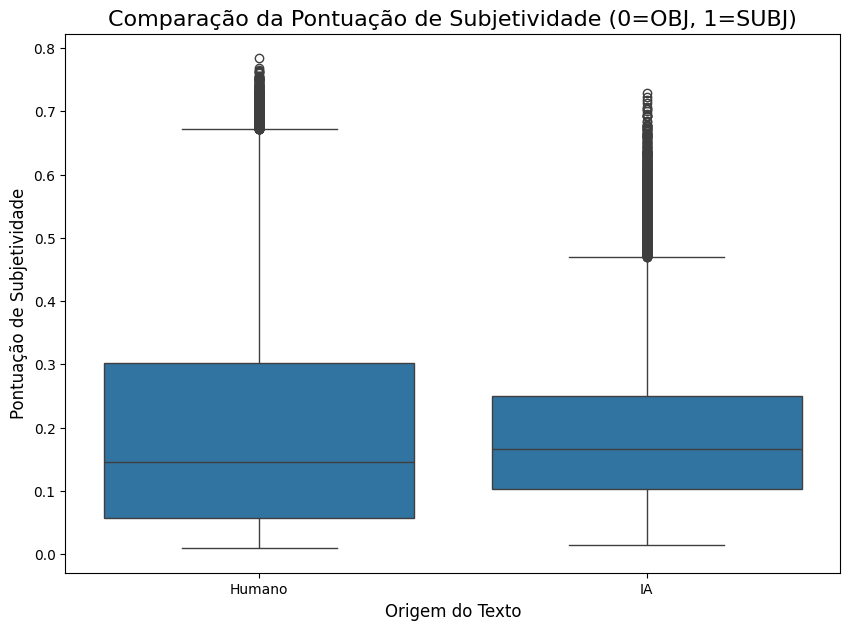

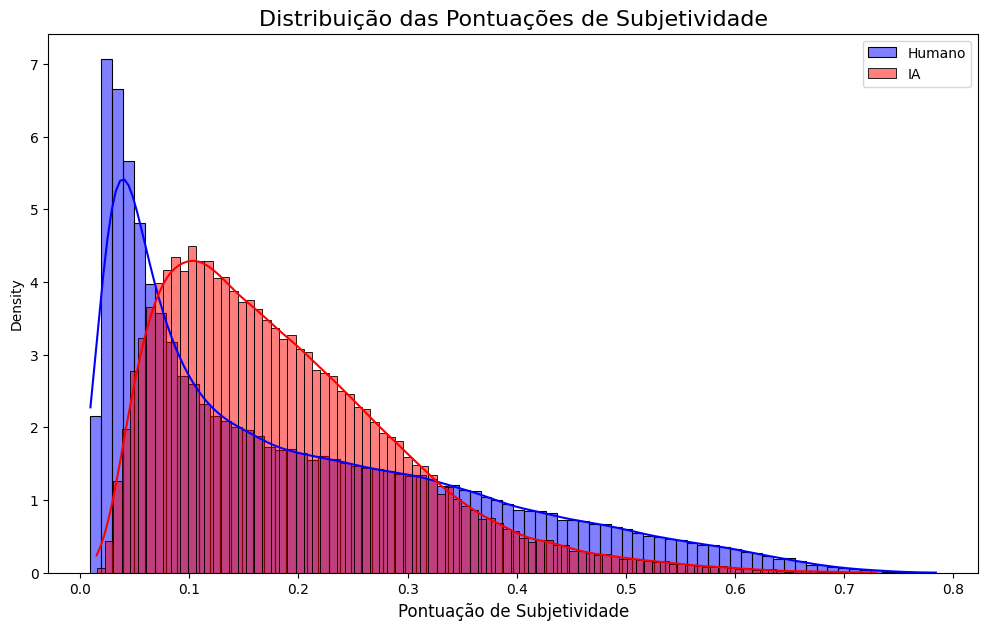

In [51]:
# caminhos dos arquivos de resultados
HUMAN_SCORES_FILE = os.path.join(CHECKPOINT_DIR, "human_scores.json")
IA_SCORES_FILE = os.path.join(CHECKPOINT_DIR, "ia_scores.json")

print("Carregando resultados salvos para plotagem...")

# carregar dados humanos
try:
    with open(HUMAN_SCORES_FILE, 'r') as f:
        human_scores = json.load(f)
    print(f"Carregados {len(human_scores)} scores humanos")
except FileNotFoundError:
    print("arquivo 'human_scores.json' não encontrado")
    human_scores = []

# carregar dados de IA
try:
    with open(IA_SCORES_FILE, 'r') as f:
        ia_scores = json.load(f)
    print(f"Carregados {len(ia_scores)} scores de IA")
except FileNotFoundError:
    print("Arquivo 'ia_scores.json' não encontrad")
    ia_scores = []

if human_scores and ia_scores:
    # limpar dados (remover qualquer pontuação de erro -1)
    human_scores_clean = [s for s in human_scores if s >= 0]
    ia_scores_clean = [s for s in ia_scores if s >= 0]
    print(f"{len(human_scores) - len(human_scores_clean)} erros removidos do corpus humano.")
    print(f"{len(ia_scores) - len(ia_scores_clean)} erros removidos do corpus de IA.")


    print("\nMédias de Subjetividade")
    print(f"Média (Humano): {np.mean(human_scores_clean):.4f}")
    print(f"Média (IA):     {np.mean(ia_scores_clean):.4f}")
    print(f"Mediana (Humano): {np.median(human_scores_clean):.4f}")
    print(f"Mediana (IA):     {np.median(ia_scores_clean):.4f}")

    # preparar dataframe para plotagem
    df_plot = pd.concat([
        pd.DataFrame({'Pontuação': human_scores_clean, 'Origem': 'Humano'}),
        pd.DataFrame({'Pontuação': ia_scores_clean, 'Origem': 'IA'})
    ])

    # boxplot
    plt.figure(figsize=(10, 7))
    sns.boxplot(x='Origem', y='Pontuação', data=df_plot)
    plt.title('Comparação da Pontuação de Subjetividade (0=OBJ, 1=SUBJ)', fontsize=16)
    plt.ylabel('Pontuação de Subjetividade', fontsize=12)
    plt.xlabel('Origem do Texto', fontsize=12)
    plt.show()

    # histograma/distribuição
    plt.figure(figsize=(12, 7))
    sns.histplot(human_scores_clean, color='blue', label='Humano', kde=True, stat="density", common_norm=False)
    sns.histplot(ia_scores_clean, color='red', label='IA', kde=True, stat="density", common_norm=False)
    plt.title('Distribuição das Pontuações de Subjetividade', fontsize=16)
    plt.xlabel('Pontuação de Subjetividade', fontsize=12)
    plt.legend()
    plt.show()
else:
    print("\nDados insuficientes para plotar. Rode a Célula 4 para gerar os arquivos de score.")